In [3]:
from matplotlib import pyplot as plt
import random
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
from ipywidgets import HBox, VBox
import functools

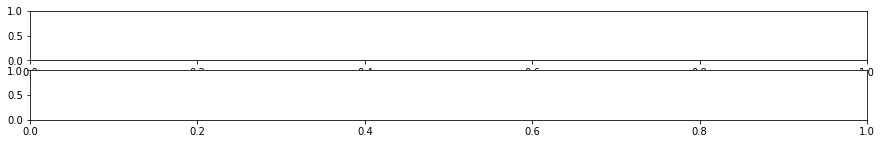

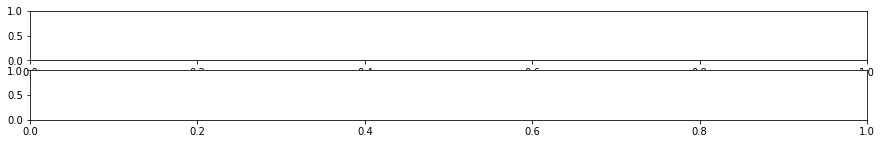

In [5]:
def throw():
    # generates a regular dice throw
    return random.choice(range(1,7))
    
    
def rally(a, d, verbose=0):
    # generates a rally where attacking player throws with a dices, defending player throws with d number of dices
    # returns the number of players lost for both teams
    assert type(a) is int and type(d) is int
    assert a<=3 and a>0
    assert d<=2 and d>0
    attack = []
    for i in range(a):
        t = throw()
        attack.append(t)
    defense = []
    for i in range(d):
        t = throw()
        defense.append(t)
    a = sorted(attack, reverse=True)
    d = sorted(defense, reverse=True)
    
    if verbose == 1:
        print("A tamado jatekos dobasa(i): ")
        for t in a:
            print(t)
        print("A vedekezo jatekos dobasa(i): ")
        for t in d:
            print(t)
            
    a_loss, d_loss = 0, 0
    for i in range(min(len(d), len(a))):
        if a[i]>d[i]: 
            d_loss += 1
        else:
            a_loss += 1
            
    if verbose == 1:
        print("A tamado ennyi jatekost veszit: "+ str(a_loss))
        print("A vedekezo ennyi jatekost veszit "+ str(d_loss))
    
    return (a_loss, d_loss)


class Field():
    def __init__(self, name):
        self.name = name
        self.color = None
        self.continent = None
        self.nr_of_soldiers = 0
        self.neighbours = None
        
        
def attack(origin, target, nr_attacking=None, nr_defending=None, stay_after_conquest=1):
    assert target in origin.neighbours
    assert origin.nr_of_soldiers > 1
    if not nr_attacking:
        nr_attacking = min(3, origin.nr_of_soldiers-1)
    if not nr_defending:
        nr_defending = min(2, target.nr_of_soldiers)
    loss_a, loss_d = rally(nr_attacking, nr_defending)
    origin.nr_of_soldiers -= loss_a
    target.nr_of_soldiers -= loss_d
    
    if origin.nr_of_soldiers==1:
        return "defense wins"
    elif target.nr_of_soldiers==0:
        target.color = origin.color
        nr_of_moving = origin.nr_of_soldiers - stay_after_conquest
        assert nr_of_moving >= nr_attacking, "Move at least as many soldiers as many were attacking"
        target.nr_of_soldiers = nr_of_moving
        origin.nr_of_soldiers = origin.nr_of_soldiers - nr_of_moving
        return "attack wins"
    else:
        return "new attack possible"
    
def attack_till_last_blood(origin, target):
    assert origin.nr_of_soldiers > 1, "the attacker has to have at least two soldiers on the field"
    battle_result = "new attack possible"
    while battle_result == "new attack possible":
        battle_result = attack(origin, target)
    if battle_result == "attack wins":
        return 1
    elif battle_result == "defense wins":
        return 0 
    else:
        raise ValueError
        
        
def calc_battle_prob(n, attacking_army_size, defending_army_size):

    wins = 0
    for i in range(n):
        origin = Field("origin")
        origin.nr_of_soldiers = attacking_army_size
        target = Field('target') 
        target.nr_of_soldiers = defending_army_size
        origin.neighbours = [target]
        win = attack_till_last_blood(origin, target)
        wins += win
    
    attack_wins_prob = wins/n
    
    return attack_wins_prob

def calc_simulated_forward_movement(attacking_army_size, defense_vector, n=10000, verbose=0):
    
    step_wish = len(defense_vector)
    
    final_position_count = [0] * (step_wish+1)
    remained_count = [0] * (attacking_army_size)

    
    for i in range(n):   

        origin = Field("origin")
        origin.nr_of_soldiers = attacking_army_size

        # inicializing target states
        target = {}
        for i in range(1, step_wish+1):
            target[i] = Field('target_'+str(i))
            target[i].nr_of_soldiers = defense_vector[i-1]
            if i == 1:
                origin.neighbours = [target[1]]
            else:
                target[i-1].neighbours = [target[i]]

        # starting war
        current_attack = origin
        current_defense = target[1]
        steps = 0

        defeat = False
        victory = False

        while not defeat and not victory:
            win = attack_till_last_blood(current_attack, current_defense)
            if win:
                steps += 1
                if steps == step_wish:
                    victory = True
                    if verbose>0:
                        print("Glorious victory!!! The army has reached it\'s goal and marched", step_wish, "states! Even ", current_defense.nr_of_soldiers, "remained.")

                else: 
                    if verbose>0:
                        print("Win! ", current_defense.nr_of_soldiers, "left")
                    current_attack = current_defense
                    current_defense = current_defense.neighbours[0]
                    if current_attack.nr_of_soldiers == 1:
                        if verbose>0:
                            print("One last brave soldier is standing. Unfortunately it cannot lauch a new attack!")
                        defeat = True
            if not win:
                defeat = True
                if verbose>0:
                    print("The army suffered a sad defeat that day :(  But their glorious army has marched", steps, "states forward")


        final_position_count[steps] += 1 
        if defeat:
            remained_count[0] += 1
        else:
            remained_count[current_defense.nr_of_soldiers] += 1
    
    final_pos_prob = []
    for i in range(len(final_position_count)):
        final_pos_prob.append(final_position_count[i]/n)
    
    remained_prob = []
    for i in range(len(remained_count)):
        remained_prob.append(remained_count[i]/n)
        
        
    return (final_pos_prob, remained_prob)




def truncate_distribution(dist):
    
    #truncating 0s from the end of the distribution
    i=0
    truncate_end = False
    while not truncate_end and i<len(dist):
        if sum(dist[i:])==0:
            truncate_end=True
            dist = dist[:i]
        else:
            i+=1
    
    #truncating 0s from the beginning
    i = 0
    align_idx = 0
    while dist[i]==0:
        align_idx += 1
        i += 1
    
    dist = dist[i:]
    
    return dist, align_idx
    
def plot_forward_march_probs(pos_probs, remained_probs):
    
    remained_probs, align_idx = truncate_distribution(remained_probs)
    
    pos_probs = [100*pos_probs[i] for i in range(len(pos_probs))]
    remained_probs = [100*remained_probs[i] for i in range(len(remained_probs))]
    fig, ax = plt.subplots(2, figsize=(15,2)) 
    pos_probs = np.expand_dims(np.array(pos_probs), axis=0)
    rem  = np.expand_dims(np.array(remained_probs), axis=0)
    sns.heatmap(pos_probs, annot=True, fmt='0.3g', cmap="YlOrRd", ax=ax[0], cbar=False)
    ax[0].set_title('Probability of number of taken fields')
    xticks = align_idx+np.arange(len(remained_probs))
    sns.heatmap(rem, annot=True, cmap="YlOrRd", xticklabels=xticks, ax=ax[1], cbar=False)
    ax[1].set_title('Probability of remaining soldiers')
    
    plt.subplots_adjust(hspace=2.5)    
    plt.show()
    

    

def update_defense_vec(*args, **kwargs):
    return args
   
    
def update_sliders(*args):
 
    clear_output()
        
    start_idx = len(def_w_list)
    to_update = int(numter.value) - start_idx
    
    if to_update>0:
        for i in range(to_update):
            new_w = widgets.IntSlider(min=1, max=50, description=f"{start_idx+i+1}. defense")
            new_w.observe(update_defense_vec, 'value')
            def_w_list.append(new_w)
            
    elif to_update<0:
        to_delete = -to_update
        for i in range(to_delete):
            def_w_list[-1].close()
            del def_w_list[-1]
   
    d = VBox([numter, attack_slider, *def_w_list, button_box])
    display(d)
    
def on_button_clicked(b):
    with output:
        clear_output()
        def_vector = []
        for i in range(len(def_w_list)):
            def_vector.append(def_w_list[i].value)
        final_pos_prob, remained_prob = calc_simulated_forward_movement(attack_slider.value, def_vector)
        plot_forward_march_probs(final_pos_prob, remained_prob)

first_time = True
def_w_list=[]

numter = widgets.Dropdown(options=[str(i) for i in range(1, 31)], value=None, description = "number of territories",
                         style = {'description_width': 'initial'})
numter_box = VBox([numter])
display(numter_box)

numter.observe(update_sliders, 'value')

attack_slider = widgets.IntSlider(min=2, max=100, description="attack")        

btn = widgets.Button(description = "Calculate")
btn.style.button_color = 'lightgreen'

output = widgets.Output()
btn.on_click(on_button_clicked)
button_box = VBox([btn,output])
